In [2]:
import os
import numpy as np
import pandas as pd

from pytrack_analysis import Multibench
from pytrack_analysis.dataio import RawData, get_session_list
from pytrack_analysis.profile import get_profile, get_scriptname, show_profile
from pytrack_analysis.posttracking import frameskips, get_displacements, mistracks, get_head_tail, get_pixel_flip
from pytrack_analysis.viz import plot_along, plot_fly, plot_interval, plot_overlay, plot_ts
import matplotlib.pyplot as plt

experiment = 'DIFF'
user = 'degoldschmidt'
ascript = '001-post_tracking.ipynb'

profile = get_profile(experiment, user, script=ascript)
folders = profile.get_folders()

colnames = ['datetime', 'elapsed_time', 'frame_dt', 'body_x',   'body_y',   'angle',    'major',    'minor']
colunits = ['Datetime', 's',            's',        'px',       'px',       'rad',      'px',       'px']
raw_data = RawData(experiment, folders, columns=colnames, units=colunits, noVideo=True)

System 'MacBook-Pro-3_x86_64_degoldschmidt' found.
Project 'DIFF' found.
[pytrack_analysis.dataio]	Loading raw data folders and file structure...found 72 sessions...done.


In [9]:
def get_preprocessed_session(raw_data, session_id, fly):
    raw_data.get_session(session_id)
    raw_data.center()
    ### for each arena
    for i_arena, each_df in enumerate(raw_data.get_data()):
        ### compute head and tail positions
        each_df['head_x'], each_df['head_y'], each_df['tail_x'], each_df['tail_y'] = get_head_tail(each_df, x='body_x', y='body_y', angle='angle', major='major')
        ### compute frame-to-frame displacements
        arena = raw_data.arenas[i_arena]
        each_df['displacement'], each_df['dx'], each_df['dy'], each_df['mov_angle'], each_df['align'], each_df['acc'] = get_displacements(each_df, x='body_x', y='body_y', angle='angle')
        ### detect mistracked frames
        each_df = mistracks(each_df, i_arena, dr='displacement', major='major', thresholds=(4*8.543, 5*8.543), keep=True)
        
        
        file_id = 4 * (session_id) + i_arena
        _file = os.path.join(folders['processed'],'pixeldiff','{}_{:03d}.csv'.format(experiment, file_id))
        
        ### flips -----
        df = pd.read_csv(_file, index_col='frame')
        hpx, tpx = np.array(df['headpx']), np.array(df['tailpx'])
        pxdf = tpx - hpx
        each_df['flip'] = np.array(pxdf < 0)        
        each_df['jump'] = each_df['acc'] > 5.
        each_df['flipped'] = each_df['displacement'] < 0.
        jumptimes = np.append(each_df.index[0], each_df.query('jump == True').index)
        jumptimes = np.append(jumptimes, each_df.index[-1])
        #if i_arena == fly:
            #print(jumptimes)
        for i, each in enumerate(jumptimes[1:]):
            dt = min(jumptimes[i+1]-jumptimes[i], 250)
            mean_flip = np.mean(each_df.loc[jumptimes[i]:jumptimes[i]+dt, 'flip'])
            mean_align = np.mean(each_df.loc[jumptimes[i]:jumptimes[i]+dt, 'align'])
            flip_decision = (mean_flip > 0.5 and mean_align < 0.) or mean_flip > 0.9 or mean_align < -0.1
            #if i_arena == fly:
                #print(jumptimes[i], dt, mean_flip, mean_align, flip_decision)
            if flip_decision:
                nheadx, nheady = np.array(each_df.loc[jumptimes[i]:jumptimes[i+1], 'tail_x']), np.array(each_df.loc[jumptimes[i]:jumptimes[i+1], 'tail_y'])
                ntailx, ntaily = np.array(each_df.loc[jumptimes[i]:jumptimes[i+1], 'head_x']), np.array(each_df.loc[jumptimes[i]:jumptimes[i+1], 'head_y']) 
                each_df.loc[jumptimes[i]:jumptimes[i+1], 'head_x'] = nheadx
                each_df.loc[jumptimes[i]:jumptimes[i+1], 'tail_x'] = ntailx
                each_df.loc[jumptimes[i]:jumptimes[i+1], 'head_y'] = nheady
                each_df.loc[jumptimes[i]:jumptimes[i+1], 'tail_y'] = ntaily
                each_df.loc[jumptimes[i]:jumptimes[i+1], 'angle'] -= np.pi
                each_df.loc[jumptimes[i]:jumptimes[i+1],'flipped'] = True
        ### flips -----
    return raw_data

def plot_arena(arena=None, spots=None, condition=None, ax=None):
    spot_colors = {'yeast': '#ffc04c', 'sucrose': '#4c8bff'}
    cond_colors = {'SAA': '#b6d7a8', 'AA': '#A4C2F4', 'S': '#EA9999', 'O': '#CCCCCC'}
    if ax is None:
        ax = plt.gca()
    ### artists
    if arena is not None:
        ax.set_xlim([-1.1*arena.ro, 1.1*arena.ro])
        ax.set_ylim([-1.1*arena.ro, 1.1*arena.ro])
        arena_border = plt.Circle((0, 0), arena.rr, color='k', fill=False)
        ax.add_artist(arena_border)
        outer_arena_border = plt.Circle((0, 0), arena.ro, color='#aaaaaa', fill=False)
        ax.add_artist(outer_arena_border)
        ax.plot(0, 0, 'o', color='black', markersize=2)
    if spots is not None:
        for each_spot in spots:
            substr = each_spot.substrate
            spot = plt.Circle((each_spot.rx, each_spot.ry), each_spot.rr, color=spot_colors[substr], alpha=0.5)
            ax.add_artist(spot)
    if condition is not None:
        if condition in cond_colors.keys():
            spot = plt.Rectangle((-arena.ro, arena.ro-2), 5, 5, color=cond_colors[condition])
            ax.add_artist(spot)
    ax.set_aspect("equal")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
    return ax

def plot_traj(data, scale, time=None, only=None):
    %matplotlib inline
    f, axes = plt.subplots(2, 2, figsize=(20,20))
    fly = 0
    for each_row in axes:
        for ax in each_row:
            arena = data.arenas[fly]
            df = data.raw_data[fly]
            if time is None:
                start, end = df.index[0], df.index[-1]
            else:
                start, end = time
            ax = plot_arena(arena=arena, spots=arena.spots, condition=data.condition[fly], ax=ax)
            x = df.loc[start:end, 'body_x']
            y = df.loc[start:end, 'body_y']
            hx = df.loc[start:end, 'head_x']
            hy = df.loc[start:end, 'head_y']
            tx = df.loc[start:end, 'tail_x']
            ty = df.loc[start:end, 'tail_y']
            if only is None or only == 'body':
                ax.plot(x/scale, y/scale, c='k')
            if only is None or only == 'tail':
                ax.scatter(tx/scale, ty/scale, c='b', s=1)
            if only is None or only == 'head':
                ax.scatter(hx/scale, hy/scale, c='r', s=1)
            fly += 1
    plt.tight_layout()
    plt.show()
    
def pdf_traj(data, scale, time=None, only=None, title=None):
    %matplotlib inline
    f, axes = plt.subplots(2, 2, figsize=(8,8), dpi=600)
    fly = 0
    for each_row in axes:
        for ax in each_row:
            arena = data.arenas[fly]
            df = data.raw_data[fly]
            if time is None:
                start, end = df.index[0], df.index[-1]
            else:
                start, end = time
            ax = plot_arena(arena=arena, spots=arena.spots, condition=data.condition[fly], ax=ax)
            x = df.loc[start:end, 'body_x']
            y = df.loc[start:end, 'body_y']
            hx = df.loc[start:end, 'head_x']
            hy = df.loc[start:end, 'head_y']
            tx = df.loc[start:end, 'tail_x']
            ty = df.loc[start:end, 'tail_y']
            if only is None or only == 'body':
                ax.plot(x/scale, y/scale, c='k')
            if only is None or only == 'tail':
                ax.scatter(tx/scale, ty/scale, c='b', s=.25)
            if only is None or only == 'head':
                ax.scatter(hx/scale, hy/scale, c='r', s=.25)
            fly += 1
    plt.tight_layout()
    f.savefig(title, dpi=600)

def pdf_merge(folder, _file):
    from PyPDF2 import PdfFileReader, PdfFileMerger
    _files = [f for f in os.listdir(folder) if '.pdf' in f]
    # Merge the files
    merger = PdfFileMerger()
    for f in _files:
        merger.append(PdfFileReader(f), 'rb')
    merger.write(_file)
    
def plot_single(data, fly, scale, time=None):
    %matplotlib inline
    f, ax = plt.subplots(1, figsize=(20,20))
    arena = data.arenas[fly]
    df = data.raw_data[fly]
    if time is None:
        start, end = df.index[0], df.index[-1]
    else:
        start, end = time
    ax = plot_arena(arena=arena, spots=arena.spots, condition=data.condition[fly], ax=ax)
    x = df.loc[start:end, 'body_x']
    y = df.loc[start:end, 'body_y']
    hx = df.loc[start:end, 'head_x']
    hy = df.loc[start:end, 'head_y']
    tx = df.loc[start:end, 'tail_x']
    ty = df.loc[start:end, 'tail_y']
    
    ax.plot(x/scale, y/scale, c='k')
    ax.scatter(tx/scale, ty/scale, c='b')
    ax.scatter(hx/scale, hy/scale, c='r')
    nfigs = 5
    scale = 4
    f_ts, axes = plt.subplots(nfigs, figsize=(5*scale,scale*nfigs*1))
    speed = df.loc[start:end, 'displacement']
    acc = df.loc[start:end, 'acc']
    jump = df.loc[start:end, 'jump']
    angle = df.loc[start:end, 'angle']
    movement = df.loc[start:end, 'mov_angle']
    align = df.loc[start:end, 'align']
    flipped = df.loc[start:end, 'flipped']
    headpx = df.loc[start:end, 'headpx']
    tailpx = df.loc[start:end, 'tailpx']
    flips = df.loc[start:end, 'flip']
    axes[0].plot(speed, c='#FD5F00')
    axes[0].plot(speed[jump>0],'k*')
    axes[1].plot(acc, c='#22225F')
    axes[2].plot(angle, c='#FD00F5')
    axes[2].plot(flipped, c='#00FDF5')
    axes[2].plot(align, c='#222222')
    axes[3].plot(headpx, c='r')
    axes[3].plot(tailpx, c='g')
    axes[4].plot(flips, c='k')
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-01-23 09:07:03.498275. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


[pytrack_analysis.dataio]	starting post-tracking analysis for session 0/72 (2017-11-24 08:26:18)...
[pytrack_analysis.dataio]	Warning: no video!
[pytrack_analysis.dataio]	Loading raw data...

/usr/local/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-01-23 09:07:04.364490. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


done.
[pytrack_analysis.arena]	loading geometry data...done.
[pytrack_analysis.food_spots]	loading food spots data...found a total of 48 spots...done.
[pytrack_analysis.posttracking]	Arena ↖ - mistracked frames: 0
[pytrack_analysis.posttracking]	Arena ↗ - mistracked frames: 0
[pytrack_analysis.posttracking]	Arena ↙ - mistracked frames: 0
[pytrack_analysis.posttracking]	Arena ↘ - mistracked frames: 0


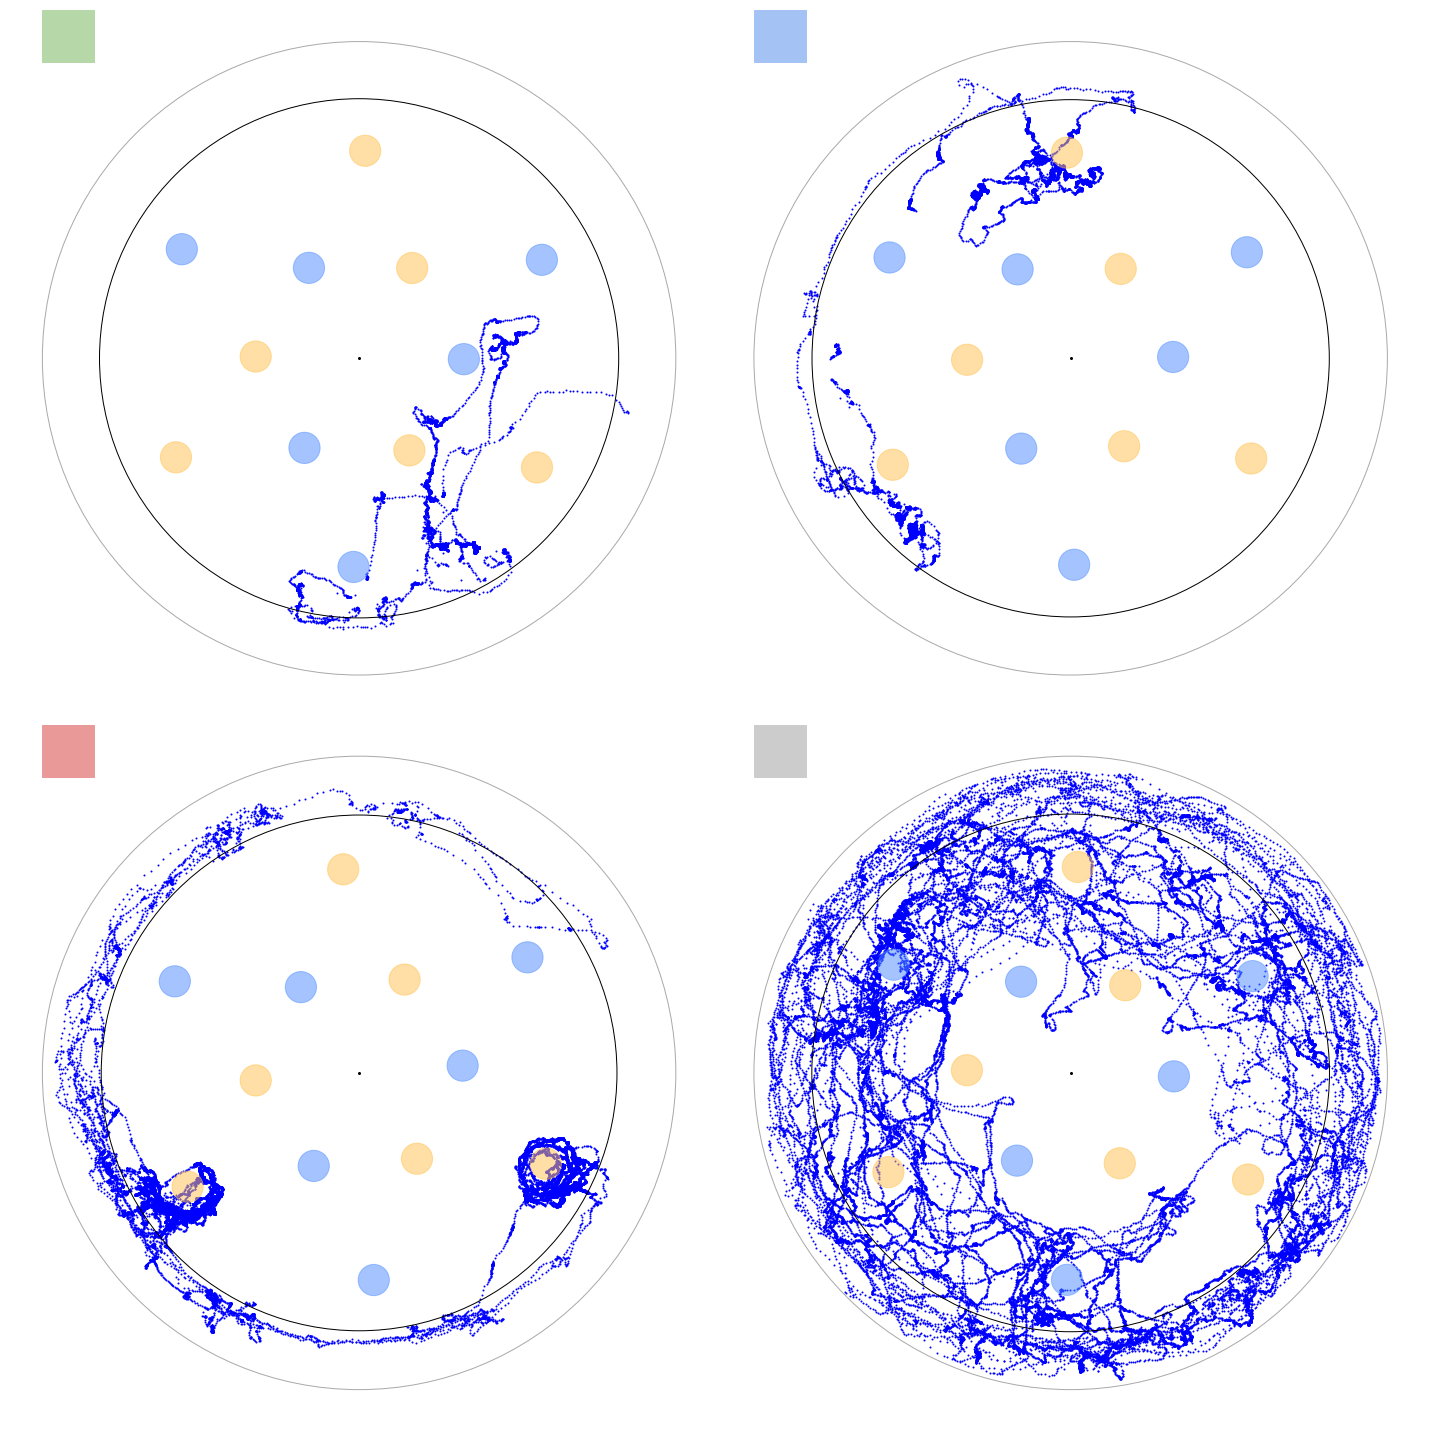

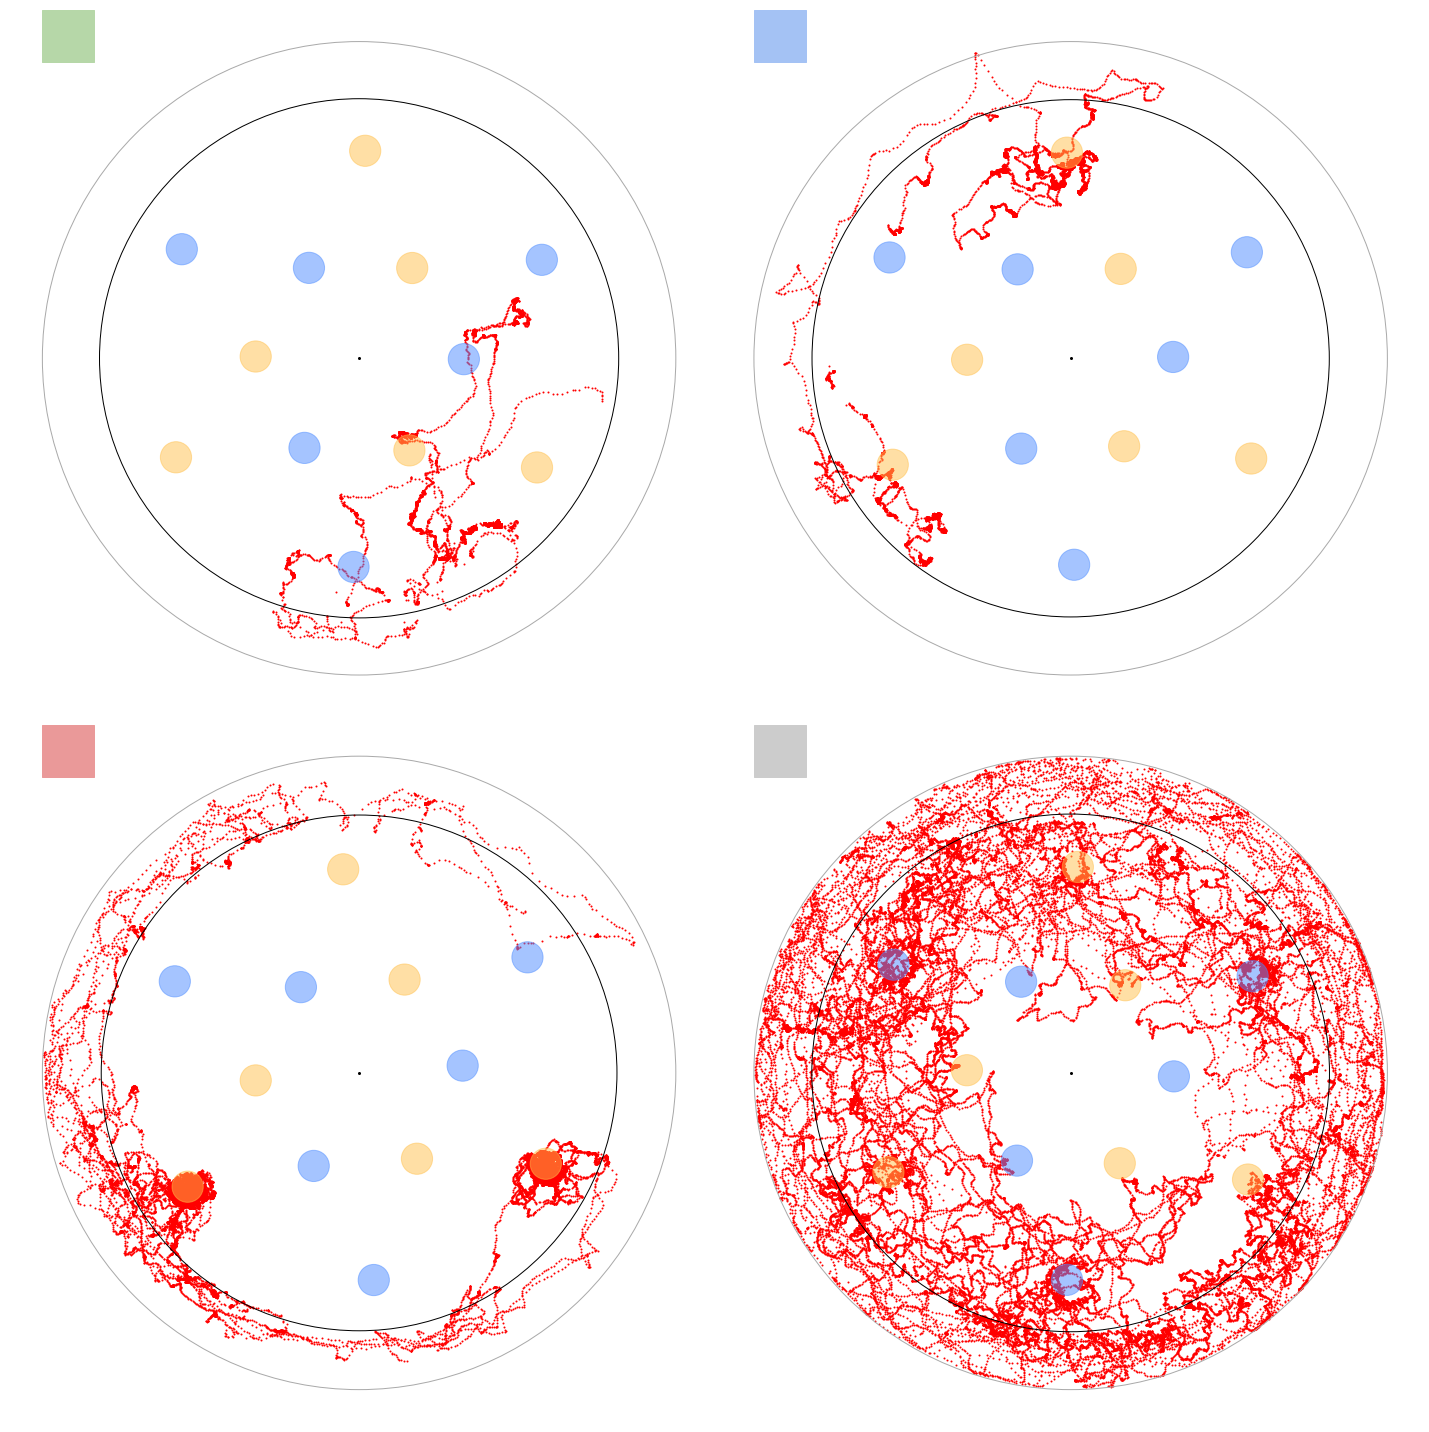

In [10]:
#for i_session in range(71):
i_session = 0
i_fly = 0
raw_data = get_preprocessed_session(raw_data, i_session, i_fly)
### scale trajectories to mm
scale = 8.543
raw_data.set_scale('fix_scale', scale, unit='mm')
raw_data.flip_y()
_fileH = "E:\\Dennis\\Google Drive\\PhD Project\\Experiments\\001-DifferentialDeprivation\\plots\\{:02d}_H.png".format(i_session)
_fileT = "E:\\Dennis\\Google Drive\\PhD Project\\Experiments\\001-DifferentialDeprivation\\plots\\{:02d}_T.png".format(i_session)
_fileB = "E:\\Dennis\\Google Drive\\PhD Project\\Experiments\\001-DifferentialDeprivation\\plots\\{:02d}_B.png".format(i_session)
plot_traj(raw_data, scale, time=(raw_data.first_frame, raw_data.last_frame), only='tail')
plot_traj(raw_data, scale, time=(raw_data.first_frame, raw_data.last_frame), only='head')
#pdf_traj(raw_data, scale, time=(raw_data.first_frame, raw_data.last_frame), only='tail', title=_fileT)
#pdf_traj(raw_data, scale, time=(raw_data.first_frame, raw_data.last_frame), only='head', title=_fileH)
#pdf_traj(raw_data, scale, time=(raw_data.first_frame, raw_data.last_frame), only='head', title=_fileH)
#plot_single(raw_data, i_fly, scale, time=(raw_data.first_frame + 3 * 1800, raw_data.first_frame + 5 * 1800))
#plot_single(raw_data, i_fly, scale, time=(12700, 13100))

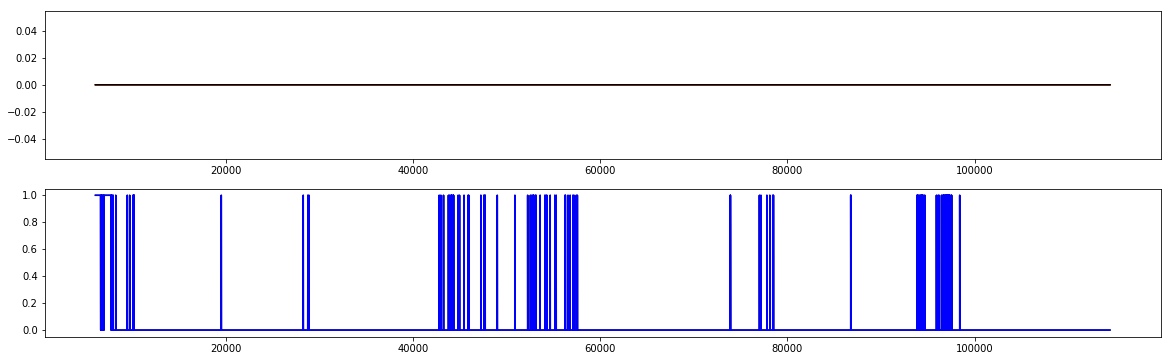

In [56]:
%matplotlib inline
figs = 2
f, ax = plt.subplots(figs,figsize=(20,3*figs))
df = raw_data.get_data(0)

ax[0].plot(df['tailpx']-df['tailpx1'], 'g-')
ax[0].plot(df['headpx']-df['headpx1'], 'r-')
ax[0].plot(df['flip'].astype(int) - df['flip1'].astype(int), 'k-')
ax[1].plot(df['flip'].astype(int), 'k-')
ax[1].plot(df['flip1'].astype(int), 'b-')
#for eachax in ax:
#    eachax.set_xlim([6100, 11000])
plt.show()

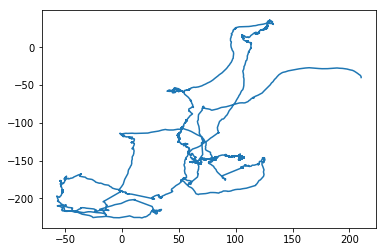

In [5]:
f, ax = plt.subplots(1)
df = raw_data.get_data(0)
ax.plot(df['body_x'], df['body_y'])

In [6]:
raw_data.get_data(i_fly).isnull().values.any()

False